In [9]:
'''
This file plots CMIP5 RCP - HIST over South Australia
/Users/earl/Desktop/Yang
and places the outputs in
/Users/earl/Dropbox/CMIP5/figures

Earl Duran 
created: 19-Mar-18
e.duran@unsw.edu.au
'''

import os
import xarray as xr
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import sys
import pickle
import itertools
def find_nearest_index(array, value):
    return int((np.abs(array - value)).argmin())
from scipy import interpolate


In [10]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [23]:
os.system('sshfs \
erd561@raijin.nci.org.au:/g/data/e14/erd561/CMIP5/bromeliad/ \
/Users/earl/Desktop/bamboo')

os.system('sshfs \
erd561@raijin.nci.org.au:/g/data/e14/erd561/wombat_jra-iaf_mom025/ \
/Users/earl/Desktop/alamanda')


0

In [47]:
# JRA-IAF stuff
data_path = '/Users/earl/Desktop/alamanda/'

tau_x = xr.open_dataset(data_path + 'tau_x_1958-2014.nc')['tau_x']
u_lat = xr.open_dataset(data_path + 'tau_x_1958-2014.nc')['yu_ocean']
u_lon1 = xr.open_dataset(data_path + 'tau_x_1958-2014.nc')['xu_ocean']
u_lon = u_lon1 + 360

# 1980 to 1999
tau_x_mean = np.mean(tau_x[22:42], axis=0)

print(tau_x[22:42].shape)
print(tau_x_mean.shape)
print(u_lat.shape)
print(u_lon.shape)

(20, 220, 281)
(220, 281)
(220,)
(281,)


In [51]:
lat_N = -20
lat_S = -60
lon_W = 100
lon_E = 170
lat_N_idx = find_nearest_index(u_lat, lat_N)
lat_S_idx = find_nearest_index(u_lat, lat_S)
lon_W_idx = find_nearest_index(u_lon, lon_W)
lon_E_idx = find_nearest_index(u_lon, lon_E)

print(u_lat[lat_S_idx:lat_N_idx])

<xarray.DataArray 'yu_ocean' (yu_ocean: 219)>
array([-59.896754, -59.771127, -59.645026, ..., -20.778954, -20.545035,
       -20.310757])
Coordinates:
  * yu_ocean  (yu_ocean) float64 -59.9 -59.77 -59.65 -59.52 -59.39 -59.26 ...
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y


In [12]:
with open('p05_index_and_pools.pkl', 'rb') as f:
    lat_warmN, lat_warmS, lon_warmW, lon_warmE, \
    SAM_index_sorted_cleaned, warm_pool_sorted_cleaned, wind_pool_sorted_cleaned = \
    pickle.load(f)

print(SAM_index_sorted_cleaned)

['IPSL-CM5A-MR', 'IPSL-CM5A-LR', 'GFDL-CM3', 'FGOALS-s2', 'CMCC-CMS', 'CMCC-CM', 'MPI-ESM-MR', 'GFDL-ESM2M', 'ACCESS1-0', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'CanESM2', 'GFDL-ESM2G', 'ACCESS1-3', 'CSIRO-Mk3-6-0', 'HadGEM2-AO', 'MRI-ESM1', 'MRI-CGCM3', 'NorESM1-M', 'IPSL-CM5B-LR', 'CNRM-CM5']


In [14]:
script_name = nb_name[:-6]
print(script_name)
figures_path = '/Users/earl/Dropbox/CMIP5/figures/'

hist_tauuo_path = '/Users/earl/Desktop/bamboo/historical/mon/ocean/tauuo/latest/'
hist_tauuo_list = sorted(os.listdir(hist_tauuo_path))

rcp85_tauuo_path = '/Users/earl/Desktop/bamboo/rcp85/mon/ocean/tauuo/latest/'
rcp85_tauuo_list = sorted(os.listdir(rcp85_tauuo_path))


p10_compare_tau_CMIP5_SAMexp_JRA-IAF


In [31]:
tauuo_hist = {}
tauuo_rcp85 = {}
tauuo_anom = {}
tauuo_lat = {}
tauuo_lon = {}

plot_list = sorted(SAM_index_sorted_cleaned)
print(plot_list)
for model in plot_list:
    print(model)
    # These models are hard to deal with:
    # MIROC5 and inmcm4 have a crazy rotated grid
    # MPI-ESM-LR has a weird grid too
    if model in ['MIROC5', 'MPI-ESM-LR', 'inmcm4']:
        continue
        
    if model in ['CESM1-WACCM']:
        r = '2'
    else:
        r = '1'
    tauuo_rcp85_data = xr.open_dataset(
        rcp85_tauuo_path + model + '_r' + r + 'i1p1_2080-2099mean.nc', decode_times=False)
    
    if model in ['EC-EARTH']:
        r = '2'
    tauuo_hist_data = xr.open_dataset(
        hist_tauuo_path + model + '_r' + r + 'i1p1_1980-1999mean.nc', decode_times=False)
    
    tauuo_hist[model] = tauuo_hist_data['tauuo'][0,:,:]
    tauuo_rcp85[model] = tauuo_rcp85_data['tauuo'][0,:,:]
    tauuo_anom[model] = tauuo_rcp85[model]-tauuo_hist[model]
        
    if len(tauuo_hist_data['lat'].shape) is 2:
        # MPI-ESM-LR and MPI-ESM-MR longitude index should be taken from the end
        if model in ['MPI-ESM-LR', 'MPI-ESM-MR']:
            tauuo_lat[model] = tauuo_hist_data['lat'][:,0]
            tauuo_lon[model] = tauuo_hist_data['lon'][-1,:]
        else:
            tauuo_lat[model] = tauuo_hist_data['lat'][:,0]
            tauuo_lon[model] = tauuo_hist_data['lon'][0,:]
    else:
        tauuo_lat[model] = tauuo_hist_data['lat'][:]
        tauuo_lon[model] = tauuo_hist_data['lon'][:]
    
    # The GFDL models run need this lon offset fix ...
    if model in ['GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M']:
        tauuo_lon[model][0:100] += 360
    
    # Also, MPI-ESM-LR and MPI-ESM-MR are flipped upside down...
    # Couldn't find a flip function in xarray...
    if model in ['MPI-ESM-LR', 'MPI-ESM-MR']:
        tauuo_hist_now = tauuo_hist[model]
        tauuo_hist[model] = np.flipud(tauuo_hist_now)
        tauuo_rcp85_now = tauuo_rcp85[model]
        tauuo_rcp85[model] = np.flipud(tauuo_rcp85_now)        
        tauuo_anom_now = tauuo_anom[model]
        tauuo_anom[model] = np.flipud(tauuo_anom_now)
        
        tauuo_lat_now = tauuo_lat[model]
        tauuo_lat[model] = np.flipud(tauuo_lat_now)
        
    # HadGEM2-AO, MRI-CGCM3 and MRI-ESM1 need to have their wind stress land masked...
    if model in ['HadGEM2-AO', 'MRI-CGCM3', 'MRI-ESM1', 'EC-EARTH']:
        # anything that satisfies the condition is SAFE
        tauuo_anom[model] = tauuo_anom[model].where((tauuo_anom[model] != 0), np.nan)
        
    print(model + ' OK!')
        
print(len(plot_list))   

['ACCESS1-0', 'ACCESS1-3', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'FGOALS-s2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-AO', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M']
ACCESS1-0
ACCESS1-0 OK!
ACCESS1-3
ACCESS1-3 OK!
CMCC-CM
CMCC-CM OK!
CMCC-CMS
CMCC-CMS OK!
CNRM-CM5
CNRM-CM5 OK!
CSIRO-Mk3-6-0
CSIRO-Mk3-6-0 OK!
CanESM2
CanESM2 OK!
FGOALS-s2
FGOALS-s2 OK!
GFDL-CM3
GFDL-CM3 OK!
GFDL-ESM2G
GFDL-ESM2G OK!
GFDL-ESM2M
GFDL-ESM2M OK!
HadGEM2-AO
HadGEM2-AO OK!
IPSL-CM5A-LR
IPSL-CM5A-LR OK!
IPSL-CM5A-MR
IPSL-CM5A-MR OK!
IPSL-CM5B-LR
IPSL-CM5B-LR OK!
MIROC-ESM
MIROC-ESM OK!
MIROC-ESM-CHEM
MIROC-ESM-CHEM OK!
MPI-ESM-MR
MPI-ESM-MR OK!
MRI-CGCM3
MRI-CGCM3 OK!
MRI-ESM1
MRI-ESM1 OK!
NorESM1-M
NorESM1-M OK!
21


In [52]:
lat_N = -20
lat_S = -60
lon_W = 100
lon_E = 170
lat_N_idx = find_nearest_index(u_lat, lat_N)
lat_S_idx = find_nearest_index(u_lat, lat_S)
lon_W_idx = find_nearest_index(u_lon, lon_W)
lon_E_idx = find_nearest_index(u_lon, lon_E)

lon_unique = u_lon[lon_W_idx:lon_E_idx]
lat_unique = u_lat[lat_S_idx:lat_N_idx]

grid_lon_unique, grid_lat_unique = np.meshgrid(lon_unique,lat_unique)
print(np.shape(grid_lon_unique))

lat_N = -17
lat_S = -63
lon_W = 97
lon_E = 173

tauuo_hist_unique = []
tauuo_rcp85_unique = []
tauuo_anom_unique = []

for idx, t in enumerate(plot_list):
    print(t)
        
    tauuo_lat_N_idx = find_nearest_index(tauuo_lat[t], lat_N)
    tauuo_lat_S_idx = find_nearest_index(tauuo_lat[t], lat_S)
    tauuo_lon_W_idx = find_nearest_index(tauuo_lon[t], lon_W)
    tauuo_lon_E_idx = find_nearest_index(tauuo_lon[t], lon_E)
    tauuo_grid_lon_now, tauuo_grid_lat_now = np.meshgrid(
        tauuo_lon[t][tauuo_lon_W_idx:tauuo_lon_E_idx], 
        tauuo_lat[t][tauuo_lat_S_idx:tauuo_lat_N_idx])
    tauuo_lon_flat = np.transpose(tauuo_grid_lon_now.flatten('F'))
    tauuo_lat_flat = tauuo_grid_lat_now.flatten('F')
    tauuo_flat_list = [tauuo_lon_flat, tauuo_lat_flat]    
    tauuo_grid_points = np.transpose(tauuo_flat_list)
    tauuo_hist_now = tauuo_hist[t][tauuo_lat_S_idx:tauuo_lat_N_idx,tauuo_lon_W_idx:tauuo_lon_E_idx]
    tauuo_rcp85_now = tauuo_rcp85[t][tauuo_lat_S_idx:tauuo_lat_N_idx,tauuo_lon_W_idx:tauuo_lon_E_idx]
    tauuo_anom_now = tauuo_anom[t][tauuo_lat_S_idx:tauuo_lat_N_idx,tauuo_lon_W_idx:tauuo_lon_E_idx]

    if t in ['CSIRO-Mk3-6-0', 'CanESM2', 'FGOALS-s2', 'HadGEM2-AO', 'MIROC-ESM-CHEM', 'MIROC-ESM']:
        tauuo_hist_now_flatten = tauuo_hist_now.stack(z=('lon', 'lat'))
        tauuo_rcp85_now_flatten = tauuo_rcp85_now.stack(z=('lon', 'lat'))
        tauuo_anom_now_flatten = tauuo_anom_now.stack(z=('lon', 'lat'))
    elif t in ['GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'MRI-CGCM3', 'MRI-ESM1']:
        tauuo_hist_now_flatten = tauuo_hist_now.stack(z=('rlon', 'rlat'))
        tauuo_rcp85_now_flatten = tauuo_rcp85_now.stack(z=('rlon', 'rlat'))
        tauuo_anom_now_flatten = tauuo_anom_now.stack(z=('rlon', 'rlat'))
    elif t in ['MPI-ESM-MR']:
        tauuo_hist_now_flatten = tauuo_hist_now.flatten('F')
        tauuo_rcp85_now_flatten = tauuo_rcp85_now.flatten('F')
        tauuo_anom_now_flatten = tauuo_anom_now.flatten('F')
    else:
        tauuo_hist_now_flatten = tauuo_hist_now.stack(z=('i', 'j'))
        tauuo_rcp85_now_flatten = tauuo_rcp85_now.stack(z=('i', 'j'))
        tauuo_anom_now_flatten = tauuo_anom_now.stack(z=('i', 'j'))
        
    tauuo_hist_interp = interpolate.griddata(tauuo_grid_points, tauuo_hist_now_flatten, 
                                           (grid_lon_unique, grid_lat_unique), 
                                           method='linear')
    tauuo_rcp85_interp = interpolate.griddata(tauuo_grid_points, tauuo_rcp85_now_flatten, 
                                           (grid_lon_unique, grid_lat_unique), 
                                           method='linear')
    tauuo_anom_interp = interpolate.griddata(tauuo_grid_points, tauuo_anom_now_flatten, 
                                           (grid_lon_unique, grid_lat_unique), 
                                           method='linear')
    
    if idx == 0:
        tauuo_hist_unique = tauuo_hist_interp
        tauuo_rcp85_unique = tauuo_rcp85_interp
        tauuo_anom_unique = tauuo_anom_interp
    else:
        tauuo_hist_unique = np.dstack((tauuo_hist_unique, tauuo_hist_interp)) 
        tauuo_rcp85_unique = np.dstack((tauuo_rcp85_unique, tauuo_rcp85_interp)) 
        tauuo_anom_unique = np.dstack((tauuo_anom_unique, tauuo_anom_interp)) 


(219, 280)
ACCESS1-0
ACCESS1-3
CMCC-CM
CMCC-CMS
CNRM-CM5
CSIRO-Mk3-6-0
CanESM2
FGOALS-s2
GFDL-CM3
GFDL-ESM2G
GFDL-ESM2M
HadGEM2-AO
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM
MIROC-ESM-CHEM
MPI-ESM-MR
MRI-CGCM3
MRI-ESM1
NorESM1-M


In [54]:
# Criteria for MMM:
good_tol = 12

tauuo_hist_MMM = np.empty([219,280])
tauuo_rcp85_MMM = np.empty([219,280])
tauuo_anom_MMM = np.empty([219,280])
for y_idx,y in enumerate(lat_unique):
    #print('lat: ' + str(y))
    
    for x_idx, x in enumerate(lon_unique):
        tauuo_histunique_now = tauuo_hist_unique[y_idx][x_idx]
        tauuo_rcp85unique_now = tauuo_rcp85_unique[y_idx][x_idx]
        tauuo_unique_now = tauuo_anom_unique[y_idx][x_idx]
        #print(thetao_unique_now)
        #print(np.shape(thetao_unique_now))
        tauuo_histidx = np.argwhere(np.isnan(tauuo_histunique_now))
        tauuo_rcp85idx = np.argwhere(np.isnan(tauuo_rcp85unique_now))
        tauuo_idx = np.argwhere(np.isnan(tauuo_unique_now))
        #print(idx)
        #print(len(idx))
        if len(tauuo_idx) <= good_tol:
            tauuo_hist_MMM[y_idx, x_idx] = np.nanmean(tauuo_histunique_now)
            tauuo_rcp85_MMM[y_idx, x_idx] = np.nanmean(tauuo_rcp85unique_now)
            tauuo_anom_MMM[y_idx, x_idx] = np.nanmean(tauuo_unique_now)
        else:
            tauuo_hist_MMM[y_idx, x_idx] = np.mean(tauuo_histunique_now)
            tauuo_rcp85_MMM[y_idx, x_idx] = np.mean(tauuo_rcp85unique_now)
            tauuo_anom_MMM[y_idx, x_idx] = np.mean(tauuo_unique_now)

# print(np.shape(tauuo_anom_MMM))
# plt.pcolor(tauuo_anom_MMM)

lat: <xarray.DataArray 'yu_ocean' ()>
array(-59.89675353719526)
Coordinates:
    yu_ocean  float64 -59.9
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-59.77112700982415)
Coordinates:
    yu_ocean  float64 -59.77
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-59.64502598120693)
Coordinates:
    yu_ocean  float64 -59.65
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-59.51844926331012)
Coordinates:
    yu_ocean  float64 -59.52
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-59.391395690652274)
Coordinates:
    yu_ocean  float64 -59.39
Attributes:
    long_name:       ucell latitude
    units:    

lat: <xarray.DataArray 'yu_ocean' ()>
array(-54.052496893222745)
Coordinates:
    yu_ocean  float64 -54.05
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-53.90547687322129)
Coordinates:
    yu_ocean  float64 -53.91
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-53.75793757684661)
Coordinates:
    yu_ocean  float64 -53.76
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-53.60987815889431)
Coordinates:
    yu_ocean  float64 -53.61
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-53.46129777085754)
Coordinates:
    yu_ocean  float64 -53.46
Attributes:
    long_name:       ucell latitude
    units:   

    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-47.59101424164287)
Coordinates:
    yu_ocean  float64 -47.59
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-47.422138282149525)
Coordinates:
    yu_ocean  float64 -47.42
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-47.252718859377666)
Coordinates:
    yu_ocean  float64 -47.25
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-47.08275570480149)
Coordinates:
    yu_ocean  float64 -47.08
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-46.912248579393875)
Coordinates:
    yu_ocean  float64 -46.91
Attributes:
    long_name:       uce

lat: <xarray.DataArray 'yu_ocean' ()>
array(-40.22064900022349)
Coordinates:
    yu_ocean  float64 -40.22
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-40.02948950490317)
Coordinates:
    yu_ocean  float64 -40.03
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-39.83779278144622)
Coordinates:
    yu_ocean  float64 -39.84
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-39.6455594762622)
Coordinates:
    yu_ocean  float64 -39.65
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-39.452790253021426)
Coordinates:
    yu_ocean  float64 -39.45
Attributes:
    long_name:       ucell latitude
    units:    

lat: <xarray.DataArray 'yu_ocean' ()>
array(-31.739806336180795)
Coordinates:
    yu_ocean  float64 -31.74
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-31.526951232842634)
Coordinates:
    yu_ocean  float64 -31.53
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-31.313609926578703)
Coordinates:
    yu_ocean  float64 -31.31
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-31.099784274590746)
Coordinates:
    yu_ocean  float64 -31.1
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-30.885476158925062)
Coordinates:
    yu_ocean  float64 -30.89
Attributes:
    long_name:       ucell latitude
    units:

lat: <xarray.DataArray 'yu_ocean' ()>
array(-22.867555576860124)
Coordinates:
    yu_ocean  float64 -22.87
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-22.63700935010543)
Coordinates:
    yu_ocean  float64 -22.64
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-22.406075615050508)
Coordinates:
    yu_ocean  float64 -22.41
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-22.17475748039895)
Coordinates:
    yu_ocean  float64 -22.17
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y
lat: <xarray.DataArray 'yu_ocean' ()>
array(-21.943058080785253)
Coordinates:
    yu_ocean  float64 -21.94
Attributes:
    long_name:       ucell latitude
    units: 

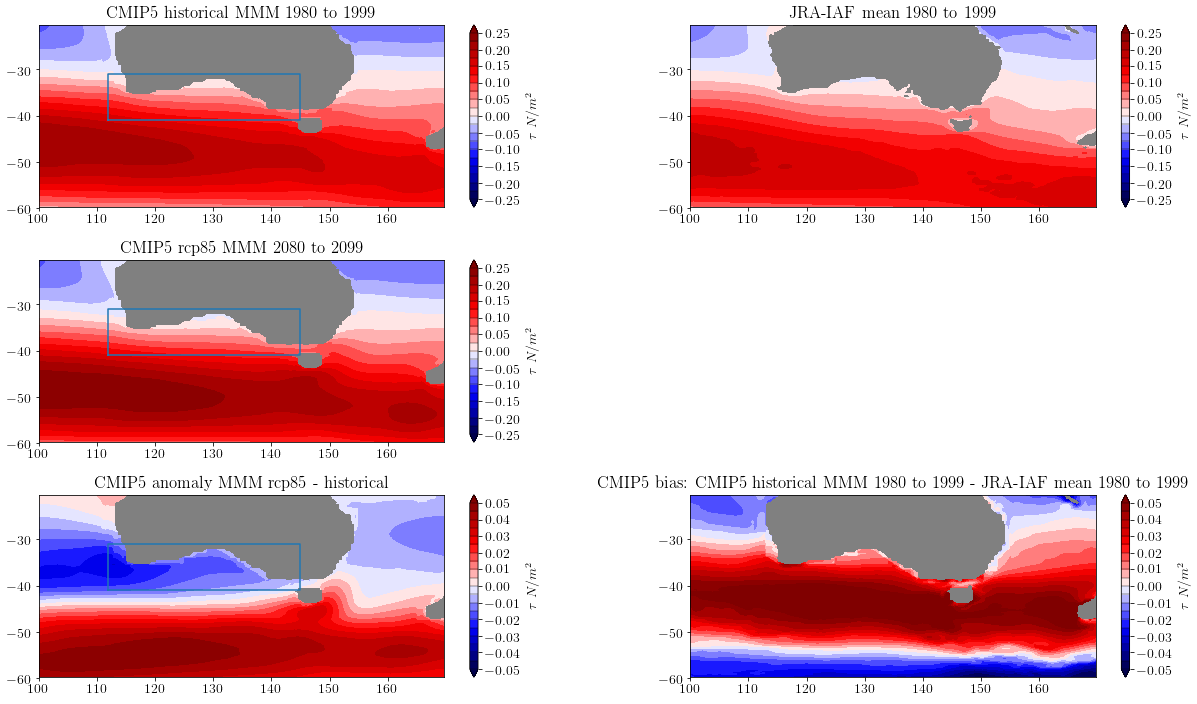

In [62]:
matplotlib.rcParams.update({'font.size': 14}) 
row = 3
col = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.close('all')
fig = plt.figure() 
fig.set_size_inches(26, 10)
marker = itertools.cycle(('v', 'P', 'o')) 

ax = plt.subplot2grid((row, col), (0,0))
cmap = plt.get_cmap('seismic')
step = 0.025
contf_lvls = np.arange(-0.25,0.25+1e-08,step)               
ax.set_facecolor('grey')
contf = plt.contourf(lon_unique, lat_unique, tauuo_hist_MMM,
                     contf_lvls, cmap=cmap, extend='both')
plot = plt.plot(
    [lon_warmW,lon_warmE,lon_warmE,lon_warmW,lon_warmW], 
    [lat_warmS,lat_warmS,lat_warmN,lat_warmN,lat_warmS])
ax.set_title('CMIP5 historical MMM 1980 to 1999')
cbar = plt.colorbar(contf, orientation='vertical', drawedges=True)
cbar.set_label(r'$\tau$ $N/m^{2}$') 
cbar.set_ticks(contf_lvls[np.arange(0,np.size(contf_lvls),2)])

ax = plt.subplot2grid((row, col), (1,0))
cmap = plt.get_cmap('seismic')
step = 0.025
contf_lvls = np.arange(-0.25,0.25+1e-08,step)                  
ax.set_facecolor('grey')
contf = plt.contourf(lon_unique, lat_unique, tauuo_rcp85_MMM,
                     contf_lvls, cmap=cmap, extend='both')
plot = plt.plot(
    [lon_warmW,lon_warmE,lon_warmE,lon_warmW,lon_warmW], 
    [lat_warmS,lat_warmS,lat_warmN,lat_warmN,lat_warmS])
ax.set_title('CMIP5 rcp85 MMM 2080 to 2099')
cbar = plt.colorbar(contf, orientation='vertical', drawedges=True)
cbar.set_label(r'$\tau$ $N/m^{2}$') 
cbar.set_ticks(contf_lvls[np.arange(0,np.size(contf_lvls),2)])

ax = plt.subplot2grid((row, col), (2,0))
cmap = plt.get_cmap('seismic')
step = 0.005
contf_lvls = np.arange(-0.05,0.05+1e-08,step)                  
ax.set_facecolor('grey')
contf = plt.contourf(lon_unique, lat_unique, tauuo_anom_MMM,
                     contf_lvls, cmap=cmap, extend='both')
plot = plt.plot(
    [lon_warmW,lon_warmE,lon_warmE,lon_warmW,lon_warmW], 
    [lat_warmS,lat_warmS,lat_warmN,lat_warmN,lat_warmS])
ax.set_title('CMIP5 anomaly MMM rcp85 - historical')
cbar = plt.colorbar(contf, orientation='vertical', drawedges=True)
cbar.set_label(r'$\tau$ $N/m^{2}$') 
cbar.set_ticks(contf_lvls[np.arange(0,np.size(contf_lvls),2)])

ax = plt.subplot2grid((row, col), (0,1))
cmap = plt.get_cmap('seismic')
step = 0.025
contf_lvls = np.arange(-0.25,0.25+1e-08,step)                
ax.set_facecolor('grey')
lat_N = -20
lat_S = -60
lon_W = 100
lon_E = 170
lat_N_idx = find_nearest_index(u_lat, lat_N)
lat_S_idx = find_nearest_index(u_lat, lat_S)
lon_W_idx = find_nearest_index(u_lon, lon_W)
lon_E_idx = find_nearest_index(u_lon, lon_E)
contf = plt.contourf(
    u_lon[lon_W_idx:lon_E_idx],
    u_lat[lat_S_idx:lat_N_idx],
    tau_x_mean[lat_S_idx:lat_N_idx,lon_W_idx:lon_E_idx], contf_lvls, cmap=cmap, extend='both')
ax.set_title('JRA-IAF mean 1980 to 1999')
cbar = plt.colorbar(contf, orientation='vertical', drawedges=True)
cbar.set_label(r'$\tau$ $N/m^{2}$') 
cbar.set_ticks(contf_lvls[np.arange(0,np.size(contf_lvls),2)])

ax = plt.subplot2grid((row, col), (2,1))
cmap = plt.get_cmap('seismic')
step = 0.005
contf_lvls = np.arange(-0.05,0.05+1e-08,step)                
ax.set_facecolor('grey')
lat_N = -20
lat_S = -60
lon_W = 100
lon_E = 170
lat_N_idx = find_nearest_index(u_lat, lat_N)
lat_S_idx = find_nearest_index(u_lat, lat_S)
lon_W_idx = find_nearest_index(u_lon, lon_W)
lon_E_idx = find_nearest_index(u_lon, lon_E)
contf = plt.contourf(
    u_lon[lon_W_idx:lon_E_idx],
    u_lat[lat_S_idx:lat_N_idx],
    tauuo_hist_MMM - tau_x_mean[lat_S_idx:lat_N_idx,lon_W_idx:lon_E_idx], contf_lvls, cmap=cmap, extend='both')
ax.set_title('CMIP5 bias: CMIP5 historical MMM 1980 to 1999 - JRA-IAF mean 1980 to 1999')
cbar = plt.colorbar(contf, orientation='vertical', drawedges=True)
cbar.set_label(r'$\tau$ $N/m^{2}$') 
cbar.set_ticks(contf_lvls[np.arange(0,np.size(contf_lvls),2)])

plt.tight_layout()

output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)

plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_' + '.png', bbox_inches='tight', dpi=200)